In [ ]:
#Import Libraries & Setting Configurations

In [3]:
import numpy as np
import pandas as pd 
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import math as mt
# import missingno as msno
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score,roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

from sklearn.linear_model import LogisticRegression


import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)


pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
#Import Data

In [5]:
titanic_ = pd.read_csv('tested.csv')
titanic_df = titanic_.copy()
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.500,0,0,330911,7.829,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000,1,0,363272,7.000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.000,0,0,240276,9.688,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.000,0,0,315154,8.662,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000,1,1,3101298,12.287,NaN,S


In [6]:
#Exploratory Data Analysis

In [7]:
def upper_col_name(dataframe):
    upper_cols = [col.upper() for col in dataframe.columns]
    dataframe.columns = upper_cols
    return dataframe.head()

In [8]:
upper_col_name(titanic_df)

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED
0,892,0,3,"Kelly, Mr. James",male,34.500,0,0,330911,7.829,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000,1,0,363272,7.000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.000,0,0,240276,9.688,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.000,0,0,315154,8.662,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000,1,1,3101298,12.287,NaN,S


In [9]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PASSENGERID  418 non-null    int64  
 1   SURVIVED     418 non-null    int64  
 2   PCLASS       418 non-null    int64  
 3   NAME         418 non-null    object 
 4   SEX          418 non-null    object 
 5   AGE          332 non-null    float64
 6   SIBSP        418 non-null    int64  
 7   PARCH        418 non-null    int64  
 8   TICKET       418 non-null    object 
 9   FARE         417 non-null    float64
 10  CABIN        91 non-null     object 
 11  EMBARKED     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


In [10]:
titanic_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PASSENGERID,418.000,1100.500,120.810,892.000,996.250,1100.500,1204.750,1309.000
SURVIVED,418.000,0.364,0.482,0.000,0.000,0.000,1.000,1.000
PCLASS,418.000,2.266,0.842,1.000,1.000,3.000,3.000,3.000
AGE,332.000,30.273,14.181,0.170,21.000,27.000,39.000,76.000
SIBSP,418.000,0.447,0.897,0.000,0.000,0.000,1.000,8.000
PARCH,418.000,0.392,0.981,0.000,0.000,0.000,0.000,9.000
FARE,417.000,35.627,55.908,0.000,7.896,14.454,31.500,512.329


In [12]:
#Selection of Categorical and Numerical Variables:

def grab_col_names(dataframe, cat_th=5, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtypes != "O" and
                   dataframe[col].nunique() < cat_th]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtypes == "O" and
                   dataframe[col].nunique() > car_th]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O" and "ID" not in col.upper()]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    return cat_cols,num_cols,cat_but_car

In [13]:
grab_col_names(titanic_df)


(['SEX', 'EMBARKED', 'SURVIVED', 'PCLASS'],
 ['AGE', 'SIBSP', 'PARCH', 'FARE'],
 ['NAME', 'TICKET', 'CABIN'])

In [14]:
cat_cols, num_cols, cat_but_car = grab_col_names(titanic_df)


In [15]:
# General Exploration for Categorical Variables:

def cat_summary(dataframe, plot=False):
    for col_name in cat_cols:
        print("############## Unique Observations of Categorical Data ###############")
        print("The unique number of "+ col_name+": "+ str(dataframe[col_name].nunique()))

        print("############## Frequency of Categorical Data ########################")
        print(pd.DataFrame({col_name : dataframe[col_name].value_counts(),
                            "Ratio": dataframe[col_name].value_counts()/len(dataframe)}))
        if plot == True:
            rgb_values = sns.color_palette("Set2", 6)
            sns.set_theme(style="darkgrid")
            ax = sns.countplot(x=dataframe[col_name], data=dataframe, palette=rgb_values)
            for p in ax.patches:
                ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=10)
            plt.show()

############## Unique Observations of Categorical Data ###############
The unique number of SEX: 2
############## Frequency of Categorical Data ########################
        SEX  Ratio
male    266  0.636
female  152  0.364


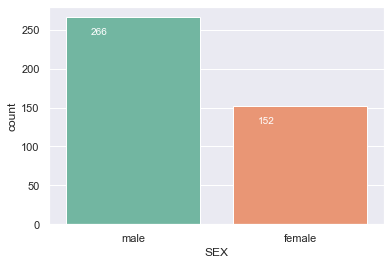

############## Unique Observations of Categorical Data ###############
The unique number of EMBARKED: 3
############## Frequency of Categorical Data ########################
   EMBARKED  Ratio
S       270  0.646
C       102  0.244
Q        46  0.110


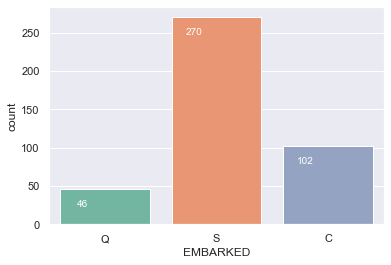

############## Unique Observations of Categorical Data ###############
The unique number of SURVIVED: 2
############## Frequency of Categorical Data ########################
   SURVIVED  Ratio
0       266  0.636
1       152  0.364


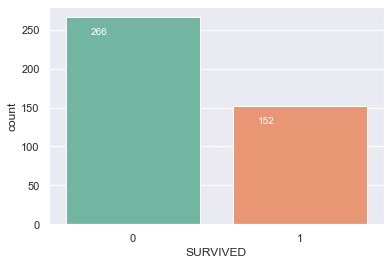

############## Unique Observations of Categorical Data ###############
The unique number of PCLASS: 3
############## Frequency of Categorical Data ########################
   PCLASS  Ratio
3     218  0.522
1     107  0.256
2      93  0.222


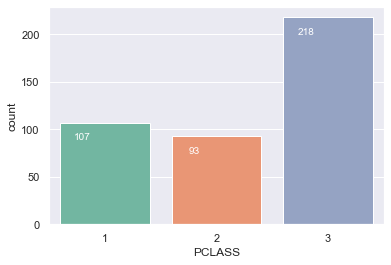

In [16]:
cat_summary(titanic_df, plot=True)

In [17]:
# General Exploration for Numerical Variables:

def num_summary(dataframe,  plot=False):
    quantiles = [0.25, 0.50, 0.75, 1]
    for col_name in num_cols:
        print("########## Summary Statistics of " +  col_name + " ############")
        print(dataframe[col_name].describe(quantiles).T)

        if plot:
            sns.histplot(data=dataframe, x=col_name  )
            plt.xlabel(col_name)
            plt.title("The distribution of "+ col_name)
            plt.grid(True)
            plt.show(block=True)


########## Summary Statistics of AGE ############
count   332.000
mean     30.273
std      14.181
min       0.170
25%      21.000
50%      27.000
75%      39.000
100%     76.000
max      76.000
Name: AGE, dtype: float64


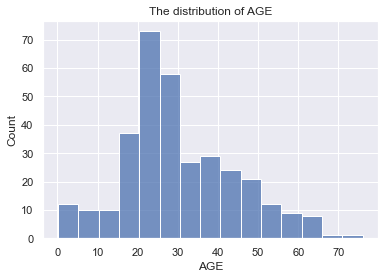

########## Summary Statistics of SIBSP ############
count   418.000
mean      0.447
std       0.897
min       0.000
25%       0.000
50%       0.000
75%       1.000
100%      8.000
max       8.000
Name: SIBSP, dtype: float64


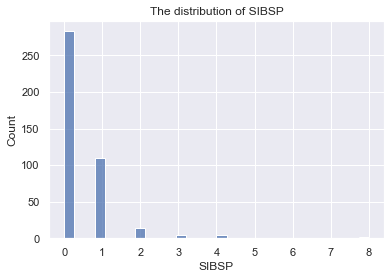

########## Summary Statistics of PARCH ############
count   418.000
mean      0.392
std       0.981
min       0.000
25%       0.000
50%       0.000
75%       0.000
100%      9.000
max       9.000
Name: PARCH, dtype: float64


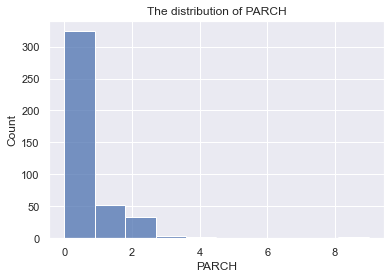

########## Summary Statistics of FARE ############
count   417.000
mean     35.627
std      55.908
min       0.000
25%       7.896
50%      14.454
75%      31.500
100%    512.329
max     512.329
Name: FARE, dtype: float64


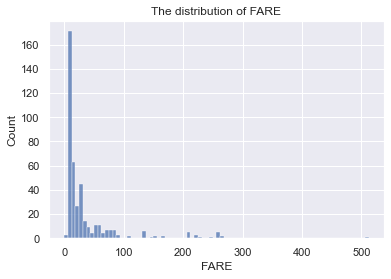

In [18]:
num_summary(titanic_df, plot=True)

In [19]:
#DATA PREPROCESSING & FEATURE ENGINEERING

In [20]:
# Only passengers have cabin numbers, so "Deck" feature can be extracted by using Cabin feature:  
titanic_df["NEW_DECK"] = titanic_df["CABIN"].notnull().astype('int')

# Name word count
titanic_df["NEW_NAME_WORD_COUNT"] = titanic_df["NAME"].apply(lambda x: len(str(x).split(" ")))

# Name that includes "Dr"
titanic_df["NEW_NAME_DR"] = titanic_df["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr. ")]))

# Family size:
titanic_df["NEW_FAMILY_SIZE"] = titanic_df["SIBSP"] + titanic_df["PARCH"] + 1

# Fare per passenger:
titanic_df['NEW_FARE_PER_PERSON'] = titanic_df['FARE'] / (titanic_df['NEW_FAMILY_SIZE'])

# Title:
titanic_df['NEW_TITLE'] = titanic_df.NAME.str.extract(' ([A-Za-z]+)\.', expand=False)

# Ticket:
titanic_df['NEW_TICKET'] = titanic_df['TICKET'].str.isalnum().astype('int')

# Age & Pclass
titanic_df["NEW_AGE_PCLASS"] = titanic_df["AGE"] * titanic_df["PCLASS"]

# Is Alone?
titanic_df["NEW_IS_ALONE"] = np.where(titanic_df['SIBSP'] + titanic_df['PARCH'] > 0, "NO", "YES") 
    
# Age Level 
titanic_df.loc[(titanic_df['AGE'] < 18), 'NEW_AGE_CAT'] = 'Young'
titanic_df.loc[(titanic_df['AGE'] >= 18) & (titanic_df['AGE'] < 56), 'NEW_AGE_CAT'] = 'Mature'
titanic_df.loc[(titanic_df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'Senior'

 # Age & Sex
titanic_df.loc[(titanic_df['SEX'] == 'male') & (titanic_df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'Young_Male'
titanic_df.loc[(titanic_df['SEX'] == 'male') & ((titanic_df['AGE'] > 21) & (titanic_df['AGE']) < 50), 'NEW_SEX_CAT'] = 'Mature_Male'
titanic_df.loc[(titanic_df['SEX'] == 'male') & (titanic_df['AGE'] > 50), 'NEW_SEX_CAT'] = 'Senior_Male'
titanic_df.loc[(titanic_df['SEX'] == 'female') & (titanic_df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'Young_Female'
titanic_df.loc[(titanic_df['SEX'] == 'female') & ((titanic_df['AGE'] > 21) & (titanic_df['AGE']) < 50), 'NEW_SEX_CAT'] = 'Mature_Female'
titanic_df.loc[(titanic_df['SEX'] == 'female') & (titanic_df['AGE'] > 50), 'NEW_SEX_CAT'] = 'Senior_Female'

In [21]:
titanic_df.columns

Index(['PASSENGERID', 'SURVIVED', 'PCLASS', 'NAME', 'SEX', 'AGE', 'SIBSP',
       'PARCH', 'TICKET', 'FARE', 'CABIN', 'EMBARKED', 'NEW_DECK',
       'NEW_NAME_WORD_COUNT', 'NEW_NAME_DR', 'NEW_FAMILY_SIZE',
       'NEW_FARE_PER_PERSON', 'NEW_TITLE', 'NEW_TICKET', 'NEW_AGE_PCLASS',
       'NEW_IS_ALONE', 'NEW_AGE_CAT', 'NEW_SEX_CAT'],
      dtype='object')

In [22]:
titanic_df.drop(columns=["PASSENGERID","NAME","TICKET","CABIN"], axis=1, inplace=True)

In [23]:
titanic_df.head(3)

,SURVIVED,PCLASS,SEX,AGE,SIBSP,PARCH,FARE,EMBARKED,NEW_DECK,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_FAMILY_SIZE,NEW_FARE_PER_PERSON,NEW_TITLE,NEW_TICKET,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,0,3,male,34.500,0,0,7.829,Q,0,3,0,1,7.829,Mr,1,103.500,YES,Mature,Mature_Male
1,1,3,female,47.000,1,0,7.000,S,0,5,0,2,3.500,Mrs,1,141.000,NO,Mature,Mature_Female
2,0,2,male,62.000,0,0,9.688,Q,0,4,0,1,9.688,Mr,1,124.000,YES,Senior,Senior_Male


In [25]:
#Outlier Detection:

In [26]:
def outlier_thresholds(dataframe, col_name, q1 = 0.25, q3 = 0.75):
    Q1 = dataframe[col_name].quantile(q1)
    Q3 = dataframe[col_name].quantile(q3)
    IQR = Q3 - Q1
    low_limit = Q1 - 1.5 * IQR
    up_limit = Q3 + 1.5 * IQR
    
    return low_limit, up_limit

In [27]:
cat_cols, num_cols, cat_but_car = grab_col_names(titanic_df)

In [28]:
for col in num_cols:
    print(col,":",outlier_thresholds(titanic_df,col))

AGE : (-6.0, 66.0)
SIBSP : (-1.5, 2.5)
PARCH : (0.0, 0.0)
FARE : (-27.5105, 66.9063)
NEW_NAME_WORD_COUNT : (0.375, 7.375)
NEW_FAMILY_SIZE : (-0.5, 3.5)
NEW_FARE_PER_PERSON : (-19.926999999999996, 53.5562)
NEW_AGE_PCLASS : (-12.5, 127.5)


In [29]:
#Showing Outliers with Boxplot:

In [30]:
def check_outlier(dataframe, q1=0.25, q3=0.75):
    for col_name in num_cols:
        low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
        if dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any(axis=None):
            sns.boxplot(x=dataframe[col_name])
            plt.show()
        else:
            return False

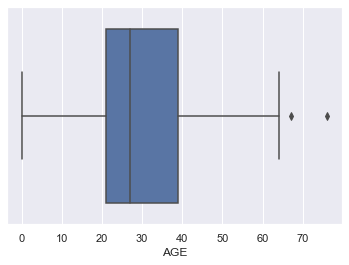

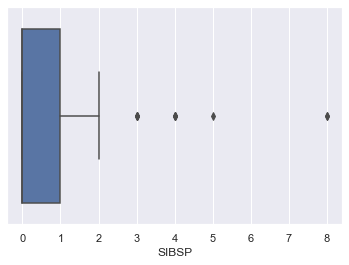

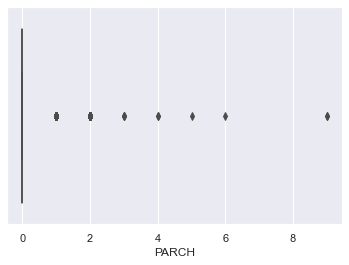

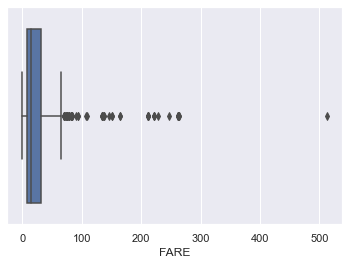

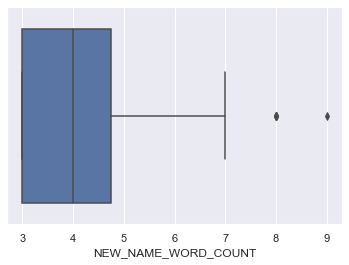

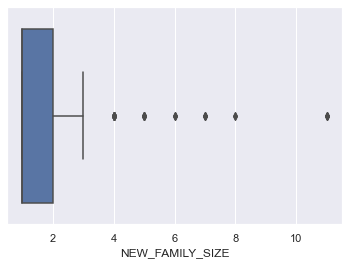

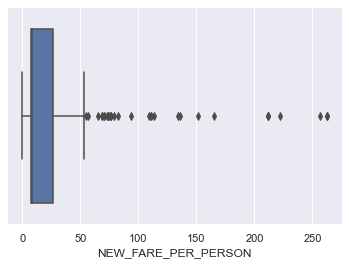

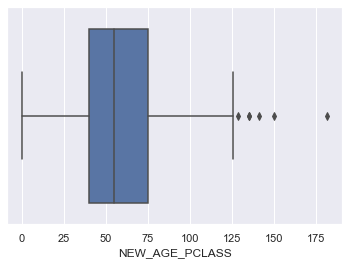

In [31]:
check_outlier(titanic_df)

In [32]:
check_outlier(titanic_df, q1=0.05, q3=0.95)

False